**STARTING GPU**

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.973037830999999
GPU (s):
0.03942994299998759
GPU speedup over CPU: 75x


In [3]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers, optimizers
import numpy as np


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

baseMapNum = 32
weight_decay = 1e-4

170500096/170498071 [==============================] - 6s 0us/step


In [4]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [5]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [6]:
def cifar10_model():
  model = Sequential()
  model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(num_classes, activation='softmax'))

  # model.summary()

  #data augmentation



  model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])
  
  return model

datagen = ImageDataGenerator(
  featurewise_center=False,
  samplewise_center=False,
  featurewise_std_normalization=False,
  samplewise_std_normalization=False,
  zca_whitening=False,
  rotation_range=15,
  width_shift_range=0.1,
  height_shift_range=0.1,
  horizontal_flip=True,
  vertical_flip=False
  )
datagen.fit(x_train)

In [7]:
model = cifar10_model()

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

In [8]:
def Plotter(acc,val_acc,loss,val_loss,l_r):
  
  plt.plot(acc, label='accuracy')
  plt.plot(val_acc, label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()


  plt.plot(loss, label='loss')
  plt.plot(val_loss, label = 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend(loc='lower right')
  plt.show()

  plt.plot(l_r, label='Learning Rate')
  # plt.plot(val_loss, label = 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('LR')
  plt.legend(loc='lower right')
  plt.show()

**Test for LR**

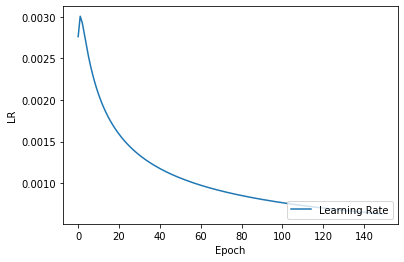

In [9]:
lr = []
epoo=150
from matplotlib import pyplot as plt
for z,batch_size in zip(range(1,epoo+1),range(5,10000,5)):

  # print(z,(batch_size)/((z+1)**(3/2))/80)

  LR = (batch_size)/((z+1)**(3/2)*80)
  LR=LR/8
  lr.append(LR)

plt.plot(lr, label='Learning Rate')
# plt.plot(val_loss, label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.legend(loc='lower right')
plt.show()

**Normal default fit** : LR and Batch Size default

In [10]:
history = model.fit(datagen.flow(x_train, y_train),
                    epochs=150,validation_data=(x_test,y_test),
                    batch_size=20)


Epoch 1/150
1563/1563 [==============================] - 33s 20ms/step - loss: 2.4197 - accuracy: 0.3273 - val_loss: 1.5078 - val_accuracy: 0.5388
Epoch 2/150
1563/1563 [==============================] - 30s 19ms/step - loss: 1.3631 - accuracy: 0.5470 - val_loss: 0.9926 - val_accuracy: 0.6833
Epoch 3/150
1563/1563 [==============================] - 30s 19ms/step - loss: 1.0887 - accuracy: 0.6424 - val_loss: 0.9995 - val_accuracy: 0.6966
Epoch 4/150
1563/1563 [==============================] - 30s 19ms/step - loss: 0.9714 - accuracy: 0.6904 - val_loss: 0.8865 - val_accuracy: 0.7271
Epoch 5/150
1563/1563 [==============================] - 30s 19ms/step - loss: 0.9083 - accuracy: 0.7162 - val_loss: 0.8264 - val_accuracy: 0.7605
Epoch 6/150
1563/1563 [==============================] - 30s 19ms/step - loss: 0.8615 - accuracy: 0.7400 - val_loss: 0.8315 - val_accuracy: 0.7615
Epoch 7/150
1563/1563 [==============================] - 30s 19ms/step - loss: 0.8440 - accuracy: 0.7495 - val_loss: 0

In [11]:
acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']

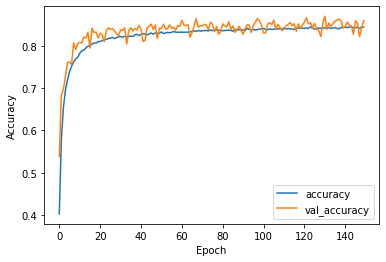

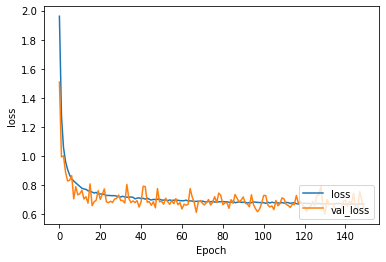

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')
plt.show()

**LR ∝ BS/Epoch**

In [13]:
model = cifar10_model()

from keras.callbacks import LearningRateScheduler

LR = 0.01
epoch = 1
batch_size = 100

val_acc = []
acc = []
val_loss = []
loss = []
l_r = []

num = 0

for z,batch_size in zip(range(1,epoo+1),range(5,10000,5)):

  LR = (batch_size)/(((z+1)**(3/2))*80)
  LR=LR/8

  print("\n\nepoch {z}, Learning Rate {LR}, Batch Size  {batch_size} "
                    .format(z=z,LR=LR,batch_size=batch_size))

  def set_LR(epoch,lr):
    global LR
    global l_r
    l_r.append(LR)
    return LR

  call = [ LearningRateScheduler(set_LR,verbose=1) ]


  history = model.fit(
            datagen.flow(x_train, y_train, 
            batch_size=batch_size),
            validation_data=(x_test,y_test),
            epochs=epoch,
            callbacks=call
            )



  acc.append(history.history['accuracy'])
  val_acc.append(history.history['val_accuracy'])
  loss.append(history.history['loss'])
  val_loss.append(history.history['val_loss'])

  # if(num >= 50 ):
  #   x = input("type anything if you want to continue >  ")
  #   num = 0
  # num += 1




epoch 1, Learning Rate 0.002762135864009951, Batch Size  5 

Epoch 00001: LearningRateScheduler reducing learning rate to 0.002762135864009951.
10000/10000 [==============================] - 70s 7ms/step - loss: 2.5848 - accuracy: 0.3174 - val_loss: 1.5611 - val_accuracy: 0.5334


epoch 2, Learning Rate 0.003007032652029301, Batch Size  10 

Epoch 00001: LearningRateScheduler reducing learning rate to 0.003007032652029301.
5000/5000 [==============================] - 44s 9ms/step - loss: 1.4864 - accuracy: 0.5624 - val_loss: 1.3134 - val_accuracy: 0.6425


epoch 3, Learning Rate 0.0029296875, Batch Size  15 

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0029296875.
3334/3334 [==============================] - 37s 11ms/step - loss: 1.2963 - accuracy: 0.6272 - val_loss: 1.1545 - val_accuracy: 0.6842


epoch 4, Learning Rate 0.002795084971874737, Batch Size  20 

Epoch 00001: LearningRateScheduler reducing learning rate to 0.002795084971874737.
2500/2500 [=============

In [14]:
acc_2 = acc
val_acc_2 = val_acc

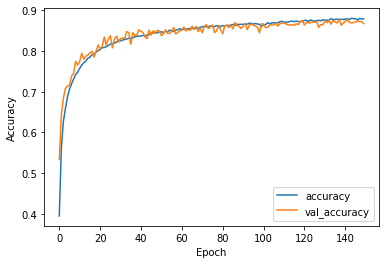

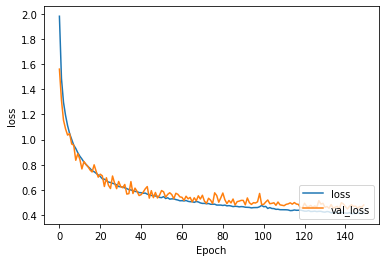

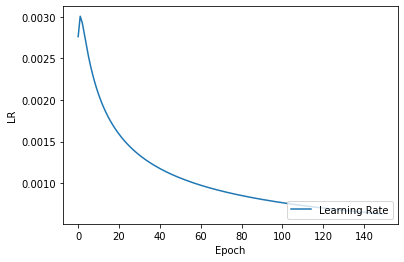

In [15]:
Plotter(acc,val_acc,loss,val_loss,l_r)

**Keeping batch size constant**

In [16]:
model = cifar10_model()

from keras.callbacks import LearningRateScheduler

LR = 0.01
epoch = 1
batch_size = 100

val_acc = []
acc = []
val_loss = []
loss = []
l_r = []
for z,batch_size in zip(range(1,epoo+1),range(5,10000,5)):

  LR = (batch_size)/(((z+1)**(3/2))*80)
  LR=LR/8

  print("\n\nepoch {z}, Learning Rate {LR}, Batch Size  {batch_size} "
                    .format(z=z,LR=LR,batch_size=batch_size))

  def set_LR(epoch,lr):
    global LR
    global l_r
    l_r.append(LR)
    return LR

  call = [ LearningRateScheduler(set_LR,verbose=1) ]

  history = model.fit(
            datagen.flow(x_train, y_train, 
            # batch_size=batch_size
            ),
            validation_data=(x_test,y_test),
            epochs=epoch,
            callbacks=call
            )



  acc.append(history.history['accuracy'])
  val_acc.append(history.history['val_accuracy'])
  loss.append(history.history['loss'])
  val_loss.append(history.history['val_loss'])



epoch 1, Learning Rate 0.002762135864009951, Batch Size  5 

Epoch 00001: LearningRateScheduler reducing learning rate to 0.002762135864009951.
1563/1563 [==============================] - 31s 19ms/step - loss: 2.4893 - accuracy: 0.3366 - val_loss: 1.3788 - val_accuracy: 0.5582


epoch 2, Learning Rate 0.003007032652029301, Batch Size  10 

Epoch 00001: LearningRateScheduler reducing learning rate to 0.003007032652029301.
1563/1563 [==============================] - 29s 19ms/step - loss: 1.2123 - accuracy: 0.6050 - val_loss: 1.1061 - val_accuracy: 0.6627


epoch 3, Learning Rate 0.0029296875, Batch Size  15 

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0029296875.
1563/1563 [==============================] - 29s 19ms/step - loss: 1.1216 - accuracy: 0.6619 - val_loss: 1.0193 - val_accuracy: 0.7163


epoch 4, Learning Rate 0.002795084971874737, Batch Size  20 

Epoch 00001: LearningRateScheduler reducing learning rate to 0.002795084971874737.
1563/1563 [=============

In [17]:
acc_3 = acc
val_acc_3 = val_acc

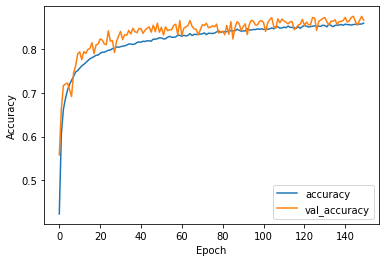

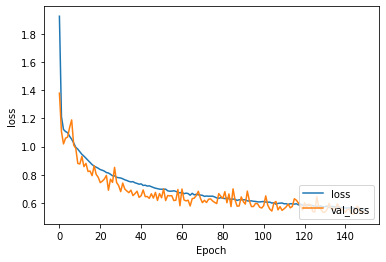

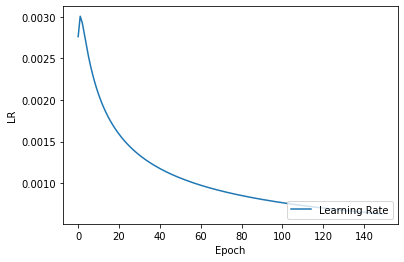

In [18]:
Plotter(acc,val_acc,loss,val_loss,l_r)

**LR constant**

In [19]:
model = cifar10_model()

from keras.callbacks import LearningRateScheduler

LR = 0.01
epoch = 1
batch_size = 100

val_acc = []
acc = []
val_loss = []
loss = []
l_r = []
for z,batch_size in zip(range(1,epoo+1),range(5,10000,5)):

  LR = (batch_size)/(((z+1)**(3/2))*80)
  LR=LR/8

  print("\n\nepoch {z}, Learning Rate {LR}, Batch Size  {batch_size} "
                    .format(z=z,LR=LR,batch_size=batch_size))

  def set_LR(epoch,lr):
    global LR
    global l_r
    l_r.append(LR)
    return LR

  call = [ LearningRateScheduler(set_LR,verbose=1) ]

  history = model.fit(
            datagen.flow(x_train, y_train, 
            batch_size=batch_size),
            validation_data=(x_test,y_test),
            epochs=epoch,
            # callbacks=call
            )



  acc.append(history.history['accuracy'])
  val_acc.append(history.history['val_accuracy'])
  loss.append(history.history['loss'])
  val_loss.append(history.history['val_loss'])



epoch 1, Learning Rate 0.002762135864009951, Batch Size  5 
10000/10000 [==============================] - 72s 7ms/step - loss: 2.5161 - accuracy: 0.3111 - val_loss: 1.2348 - val_accuracy: 0.6061


epoch 2, Learning Rate 0.003007032652029301, Batch Size  10 
5000/5000 [==============================] - 46s 9ms/step - loss: 1.2112 - accuracy: 0.6181 - val_loss: 1.0306 - val_accuracy: 0.6902


epoch 3, Learning Rate 0.0029296875, Batch Size  15 
3334/3334 [==============================] - 37s 11ms/step - loss: 1.0515 - accuracy: 0.6846 - val_loss: 0.9392 - val_accuracy: 0.7352


epoch 4, Learning Rate 0.002795084971874737, Batch Size  20 
2500/2500 [==============================] - 34s 14ms/step - loss: 0.9684 - accuracy: 0.7156 - val_loss: 0.8682 - val_accuracy: 0.7576


epoch 5, Learning Rate 0.0026578664743741078, Batch Size  25 
2000/2000 [==============================] - 33s 16ms/step - loss: 0.9085 - accuracy: 0.7412 - val_loss: 0.8035 - val_accuracy: 0.7817


epoch 6, Learnin

In [20]:
acc_4 = acc
val_acc_4 = val_acc

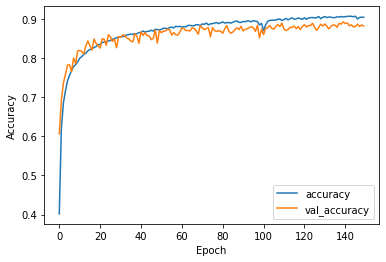

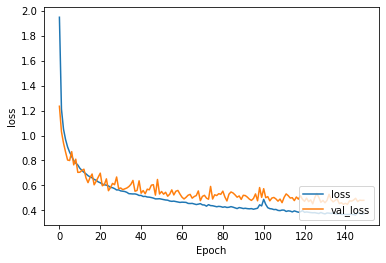

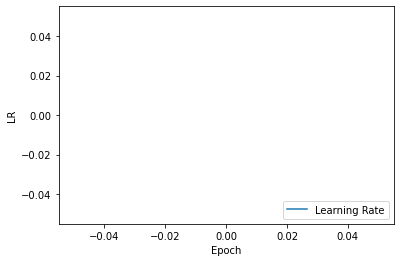

In [21]:
Plotter(acc,val_acc,loss,val_loss,l_r)

**Plotting all of them**

---



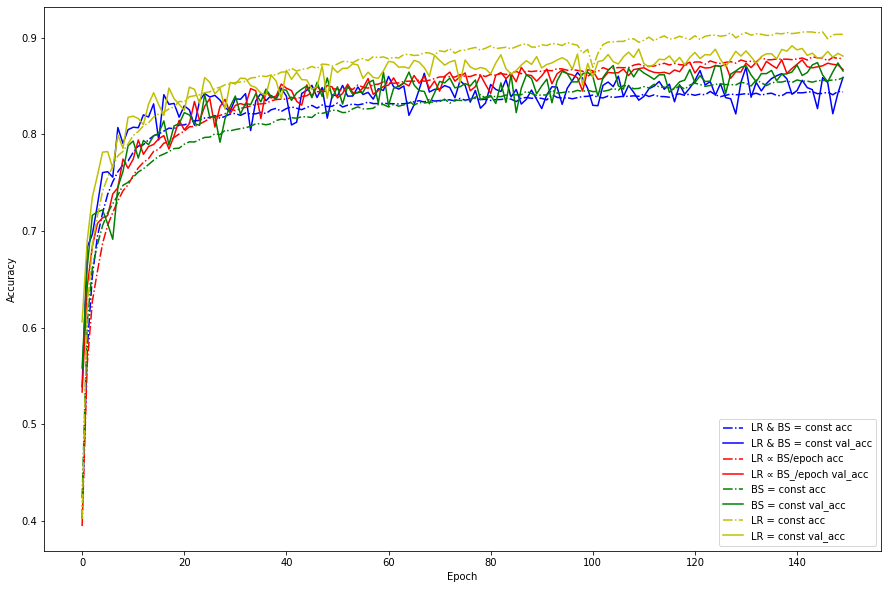

In [22]:
plt.figure(figsize=(15, 10))

plt.plot(acc_1, label='LR & BS = const acc',ls='-.',c='b')
plt.plot(val_acc_1, label = 'LR & BS = const val_acc',c='b')
plt.plot(acc_2, label='LR ∝ BS/epoch acc',ls='-.',c='r')
plt.plot(val_acc_2, label = 'LR ∝ BS_/epoch val_acc',c='r')
plt.plot(acc_3, label='BS = const acc',ls='-.',c='g')
plt.plot(val_acc_3, label = 'BS = const val_acc',c='g')
plt.plot(acc_4, label='LR = const acc',ls='-.',c='y')
plt.plot(val_acc_4, label = 'LR = const val_acc',c='y')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


# case4_fashion_acc,case4_fashion_val_acc0

In [23]:
acc_1_dif = []
for i in range(len(acc_1)): acc_1_dif.append(acc_1[i] - val_acc_1[i]) 
acc_2_dif = []
for i in range(len(acc_2)): acc_2_dif.append(acc_2[i][0] - val_acc_2[i][0]) 
acc_3_dif = []
for i in range(len(acc_3)): acc_3_dif.append(acc_3[i][0] - val_acc_3[i][0]) 
acc_4_dif = []
for i in range(len(acc_4)): acc_4_dif.append(acc_4[i][0] - val_acc_4[i][0]) 

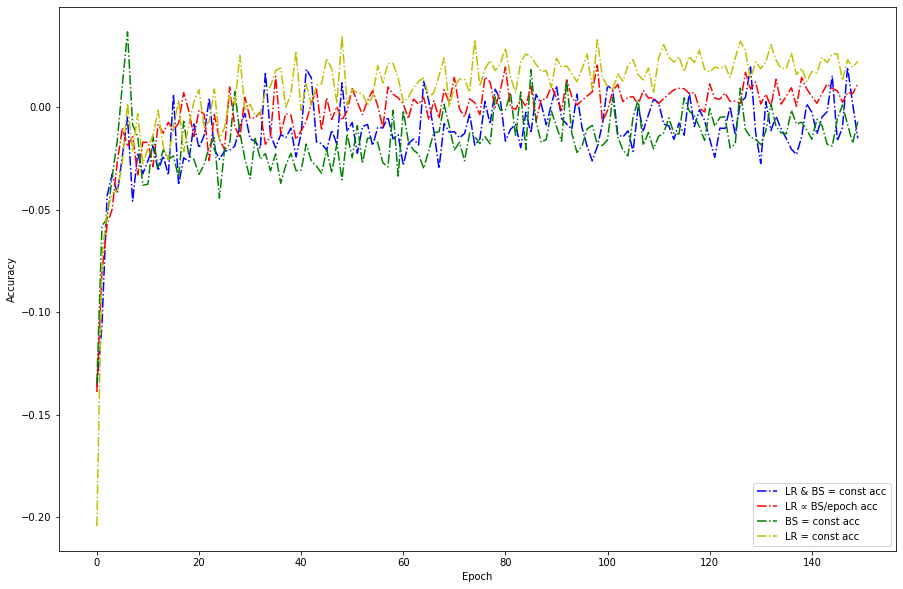

In [24]:
plt.figure(figsize=(15, 10))

plt.plot(acc_1_dif, label='LR & BS = const acc',ls='-.',c='b')
# plt.plot(val_acc_1, label = 'LR & BS = const val_acc',c='b')
plt.plot(acc_2_dif, label='LR ∝ BS/epoch acc',ls='-.',c='r')
# plt.plot(val_acc_2, label = 'LR ∝ BS_/epoch val_acc',c='r')
plt.plot(acc_3_dif, label='BS = const acc',ls='-.',c='g')
# plt.plot(val_acc_3, label = 'BS = const val_acc',c='g')
plt.plot(acc_4_dif, label='LR = const acc',ls='-.',c='y')
# plt.plot(val_acc_4, label = 'LR = const val_acc',c='y')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()